In [1]:
library(tidyverse)
library(ggpubr)
library(Seurat)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Registered S3 method overwritten by 'spatstat.geom':
  method     from
  print.boxx cli 

Attaching SeuratObject



In [2]:
celltypeColors = c(
"mitosis"="#bebebe","blood"="#ff9400",
"ExE endoderm"="#fec44f", "ExE ectoderm"="#cab2d6","early neurons"="#1F62A6", "mix late mesenchyme"="#BD342F",
"epiblast and PS"="#addd8e",
#neural
"neural ectoderm"="#AECBE6","NMP"="#96B9DB","neural tube"="#7EA8D0","notochord"="#6696C6","radial glias"="#4F85BB","oligodendrocytes and progenitors"="#3773B1","schwann cell precursors"="#08519C",
#mesodermal
"early mesoderm"="#FC9272","ExE mesoderm"="#EF7F64","early mesenchyme"="#E36C57","intermediate mesoderm"="#D6594A", "myocytes"="#CA473C",
"endoderm"="#fe9929","epithelial cells"="#fa9fb5")

cellcyclecolors = c("G0"="#762a83","G1"="#c2a5cf","Early-S"="#99d8c9","Mid-S"="#66c2a4","Late-S"="#41ae76","G2"="#238b45","M"="#ea6e34")

hires <- readRDS("/shareb/zliu//analysis/hires_mouse_dev/hires_mouse_emb_dev.new.rds")

In [3]:
DefaultAssay(hires) <- "SCT"
Idents(hires) <- hires$celltype

In [4]:
mm10 <- read_tsv("/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = F)
names(mm10) <- c("chrom","start","end","id","name","strand")
mm10 <- mm10 %>% mutate(length = end - start) %>% arrange(desc(length)) %>% group_by(name) %>% dplyr::slice(1) %>% ungroup() %>% valr::bed_sort() %>% select(-length)
mm10_tss <- mm10 %>% mutate(tss = ifelse(strand =="+",start,end))%>% mutate(end = tss + 1) %>% select(chrom,tss,end,name,strand) %>% mutate(end = tss + 1,gene = name)

Rows: 55335 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): X1, X4, X5, X6
dbl (2): X2, X3

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
read_compartment <- function(lineage){
    path = paste0("/shareb/zliu//analysis/hires_mouse_dev/figure3_related/pileup/processed/compartment/",lineage,".compartment.100k.cis.vecs.tsv")
    return(read_table(path) %>% mutate(lineage = lineage))
}
celltypes <- hires[[]] %>% pull(celltype) %>% unique() %>% str_replace_all(" ","_")
combine <-  (bind_rows(map(celltypes,read_compartment)) %>% mutate(compartment = ifelse(E1<=0,"B","A")) %>% na.omit()) %>% suppressWarnings() %>% suppressMessages()
combine <- combine %>% filter(lineage != "mitosis")  %>% filter(chrom %in% paste0("chr",seq(1:19)))

In [6]:
calc_AB_geneexp_fc <- function(celltype1, celltype2){
    compare <- combine %>% filter(lineage %in% c(celltype1,celltype2)) %>% select(chrom,start,end,lineage,compartment) %>% 
        spread(lineage,compartment) %>%na.omit()
    names(compare) <- c("chrom","start","end","celltype1","celltype2")
    compare <- compare %>% 
       mutate(type = ifelse(celltype1 != celltype2,paste0("celltype1 ",celltype1),"stable")) #%>%
       #group_by(type) %>% summarise(count = n())
    diff_exp <- FindMarkers(hires,`ident.1` = celltype1%>% str_replace_all("_"," "),`ident.2` = celltype2%>% str_replace_all("_"," "),logfc.threshold = 0)
    gene_type <- valr::bed_intersect(mm10,compare) %>% select(name.x,type.y) %>% unique()
    names(gene_type) <- c("name","type")

    pdata <- diff_exp %>% rownames_to_column("name") %>% left_join(gene_type) %>% na.omit() 
    return(pdata)
}

In [7]:
pdata <- rbind(
      calc_AB_geneexp_fc("early_mesoderm","neural_ectoderm") %>% mutate(group = "EM_NE"),
      calc_AB_geneexp_fc("early_neurons","mix_late_mesenchyme") %>% mutate(group = "EN_MLM"),
      calc_AB_geneexp_fc("ExE_ectoderm","ExE_endoderm") %>% mutate(group = "Xecto_Xendo")
)

Joining, by = "name"
Joining, by = "name"
Joining, by = "name"


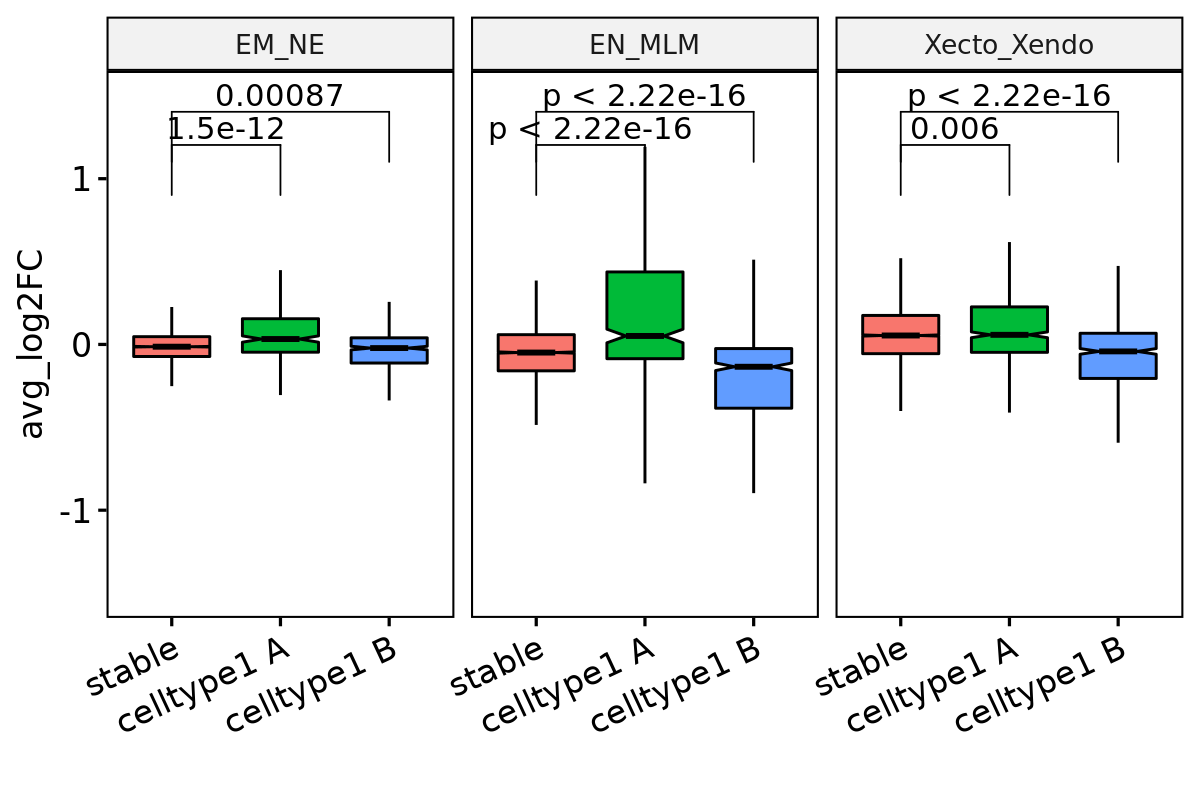

In [8]:
options(repr.plot.width=6,repr.plot.height=4,repr.plot.res=200)
pdata %>% 
    ggboxplot(x="type",y="avg_log2FC",fill = "type",notch = T,outlier.shape = NA,facet.by = "group") +NoLegend() + coord_cartesian(ylim = c(-1.5,1.5))+ 
    stat_compare_means(comparisons = list(c("celltype1 A","stable"),c("celltype1 B","stable")),label.y = c(0.7,0.9))+ 
    theme(axis.text.x = element_text(angle = 25, vjust = 1, hjust=1)) + xlab("")

In [9]:
temp <- calc_AB_geneexp_fc("early_neurons","mix_late_mesenchyme") %>% mutate(group = "EN_MLM")

Joining, by = "name"


In [10]:
library("ggExtra")

In [11]:
celltype1 = "early_neurons"
celltype2 = "mix_late_mesenchyme"
compare <- combine %>% filter(lineage %in% c(celltype1,celltype2)) %>% select(chrom,start,end,lineage,E1) %>% 
        spread(lineage,E1) %>%na.omit()
    names(compare) <- c("chrom","start","end","celltype1","celltype2")
comparediff <- compare %>% group_by(chrom) %>% 
    mutate(celltype1 = as.vector(scale(celltype1)),celltype2 = as.vector(scale(celltype2)),diff=celltype1-celltype2) %>% 
    valr::bed_intersect(mm10) %>% select(diff.x,name.y) %>% unique() %>% group_by(name.y) %>% summarise(diff = mean(diff.x))
names(comparediff) <- c("name","diff")

Joining, by = "name"


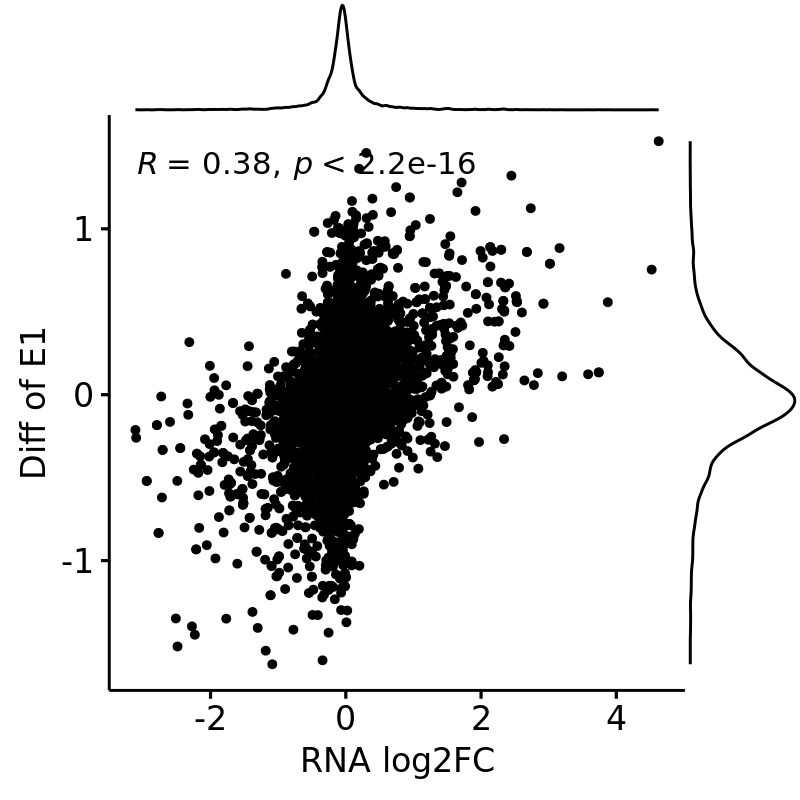

In [12]:
options(repr.plot.width=4,repr.plot.height=4,repr.plot.res=200)
p <- comparediff %>% left_join(temp) %>% na.omit() %>% ggscatter(x="avg_log2FC",y="diff",cor.coef = T,size=1) + xlab("RNA log2FC") + ylab("Diff of E1")
ggMarginal(p, type = "density") 

In [31]:
celltype2 = "mix_late_mesenchyme"
celltype1 = "epiblast_and_PS"

compare <- combine %>% filter(lineage %in% c(celltype1,celltype2)) %>% select(chrom,start,end,lineage,E1) %>% 
        spread(lineage,E1) %>%na.omit()
    names(compare) <- c("chrom","start","end","celltype1","celltype2")
comparediff <- compare %>% group_by(chrom) %>% mutate(diff = celltype1 - celltype2) %>% 
    #mutate(celltype1 = as.vector(scale(celltype1)),celltype2 = as.vector(scale(celltype2)),diff=celltype1-celltype2) %>% 
    valr::bed_intersect(mm10) %>% select(diff.x,name.y) %>% unique() %>% group_by(name.y) %>% summarise(diff = mean(diff.x))
names(comparediff) <- c("name","diff")
RNA_diff_expression = FindMarkers(hires,`ident.1` = celltype1%>% str_replace_all("_"," "),`ident.2` = celltype2%>% str_replace_all("_"," "),logfc.threshold = 0) %>% rownames_to_column("name") 

options(repr.plot.width=3,repr.plot.height=3,repr.plot.res=200)
p <- comparediff %>% left_join(RNA_diff_expression) %>% na.omit() %>% ggscatter(x="avg_log2FC",y="diff",cor.coef = T,size=1) + xlab("RNA log2FC") + ylab("Diff of E1")
ggMarginal(p, type = "density") %>% ggsave(filename = "MLM_EPI_compartment_corr.svg",height =4 ,width = 4)

Joining, by = "name"


Joining, by = "name"


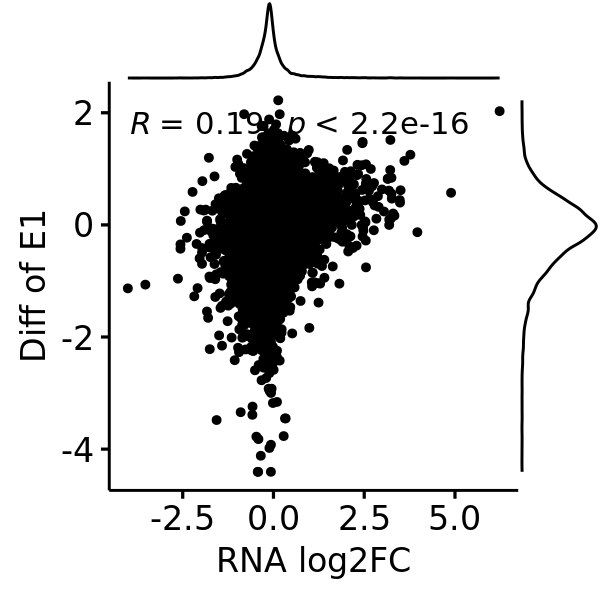

In [27]:
celltype1 = "early_neurons"
celltype2 = "epiblast_and_PS"

compare <- combine %>% filter(lineage %in% c(celltype1,celltype2)) %>% select(chrom,start,end,lineage,E1) %>% 
        spread(lineage,E1) %>%na.omit()
    names(compare) <- c("chrom","start","end","celltype1","celltype2")
comparediff <- compare %>% group_by(chrom) %>% 
    mutate(celltype1 = as.vector(scale(celltype1)),celltype2 = as.vector(scale(celltype2)),diff=celltype1-celltype2) %>% 
    valr::bed_intersect(mm10) %>% select(diff.x,name.y) %>% unique() %>% group_by(name.y) %>% summarise(diff = mean(diff.x))
names(comparediff) <- c("name","diff")
RNA_diff_expression = FindMarkers(hires,`ident.1` = celltype1%>% str_replace_all("_"," "),`ident.2` = celltype2%>% str_replace_all("_"," "),logfc.threshold = 0) %>% rownames_to_column("name") 

options(repr.plot.width=3,repr.plot.height=3,repr.plot.res=200)
p <- comparediff %>% left_join(RNA_diff_expression) %>% na.omit() %>% ggscatter(x="avg_log2FC",y="diff",cor.coef = T,size=1) + xlab("RNA log2FC") + ylab("Diff of E1")
ggMarginal(p, type = "density") 

In [30]:
options(repr.plot.width=4,repr.plot.height=4,repr.plot.res=200)
p <- comparediff %>% left_join(RNA_diff_expression) %>% na.omit() %>% ggscatter(x="avg_log2FC",y="diff",cor.coef = T,size=1) + xlab("RNA log2FC") + ylab("Diff of E1")
ggMarginal(p, type = "density")  %>% ggsave(filename = "EN_EPI_compartment_corr.svg",height =4 ,width = 4)

Joining, by = "name"


In [ ]:
celltype1 = "ExE_ectoderm"
celltype2 = "ExE_endoderm"
compare <- combine %>% filter(lineage %in% c(celltype1,celltype2)) %>% select(chrom,start,end,lineage,E1) %>% 
        spread(lineage,E1) %>%na.omit()
    names(compare) <- c("chrom","start","end","celltype1","celltype2")
comparediff <- compare %>% group_by(chrom) %>% 
    mutate(celltype1 = as.vector(scale(celltype1)),celltype2 = as.vector(scale(celltype2)),diff=celltype1-celltype2) %>% 
    valr::bed_intersect(mm10) %>% select(diff.x,name.y) %>% unique() %>% group_by(name.y) %>% summarise(diff = mean(diff.x))
names(comparediff) <- c("name","diff")
RNA_diff_expression = FindMarkers(hires,`ident.1` = celltype1%>% str_replace_all("_"," "),`ident.2` = celltype2%>% str_replace_all("_"," "),logfc.threshold = 0) %>% rownames_to_column("name") 

options(repr.plot.width=4,repr.plot.height=4,repr.plot.res=200)
p <- comparediff %>% left_join(RNA_diff_expression) %>% na.omit() %>% ggscatter(x="avg_log2FC",y="diff",cor.coef = T,size=1) + xlab("RNA log2FC") + ylab("Diff of E1")
ggMarginal(p, type = "density") 

celltype1 = "ExE_ectoderm"
celltype2 = "ExE_endoderm"
compare <- combine %>% filter(lineage %in% c(celltype1,celltype2)) %>% select(chrom,start,end,lineage,E1) %>% 
        spread(lineage,E1) %>%na.omit()
    names(compare) <- c("chrom","start","end","celltype1","celltype2")
comparediff <- compare %>% group_by(chrom) %>% 
    mutate(celltype1 = as.vector(scale(celltype1)),celltype2 = as.vector(scale(celltype2)),diff=celltype1-celltype2) %>% 
    valr::bed_intersect(mm10) %>% select(diff.x,name.y) %>% unique() %>% group_by(name.y) %>% summarise(diff = mean(diff.x))
names(comparediff) <- c("name","diff")
RNA_diff_expression = FindMarkers(hires,`ident.1` = celltype1%>% str_replace_all("_"," "),`ident.2` = celltype2%>% str_replace_all("_"," "),logfc.threshold = 0) %>% rownames_to_column("name") 

options(repr.plot.width=4,repr.plot.height=4,repr.plot.res=200)
p <- comparediff %>% left_join(RNA_diff_expression) %>% na.omit() %>% ggscatter(x="avg_log2FC",y="diff",cor.coef = T,size=1) + xlab("RNA log2FC") + ylab("Diff of E1")
ggMarginal(p, type = "density") 

# scAB version of this plot

In [15]:
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/plotFun.R")
source("/shareb/zliu//analysis/hires_gastrulation/CHARMtools/Rlibs/compartment_ana.R")

In [16]:
genes <- read_table("~/share/Data/public/ref_genome/mouse_ref/M23/raw_data/gene.bed",col_names = c("chr","start","end","id","name","strand")) %>% group_by(name) %>% slice(1)
resolution =1000000


── Column specification ────────────────────────────────────────────────────────
cols(
  chr = col_character(),
  start = col_double(),
  end = col_double(),
  id = col_character(),
  name = col_character(),
  strand = col_character()
)



In [17]:
meso_ecto_data <- getCpGDiffVocanoPlotData(hires,c("early neurons"),c("mix late mesenchyme"),genes,1000000,slot_cpg = "cpg")
meso_ecto_plot <- plotCpGDiffVocanoPlot(meso_ecto_data,"neuron vs. mesenchyme",text_x_Pos = -0.1,scale_factor = 1)
b <- meso_ecto_plot + theme_classic()+ ggtitle("") + xlab("Mean difference") + ylab("-log10(P-value)")

Joining, by = c("chr", "pos")
Joining, by = "name"


[1] "mean difference of CpG of all gene is 0.030962824735253"


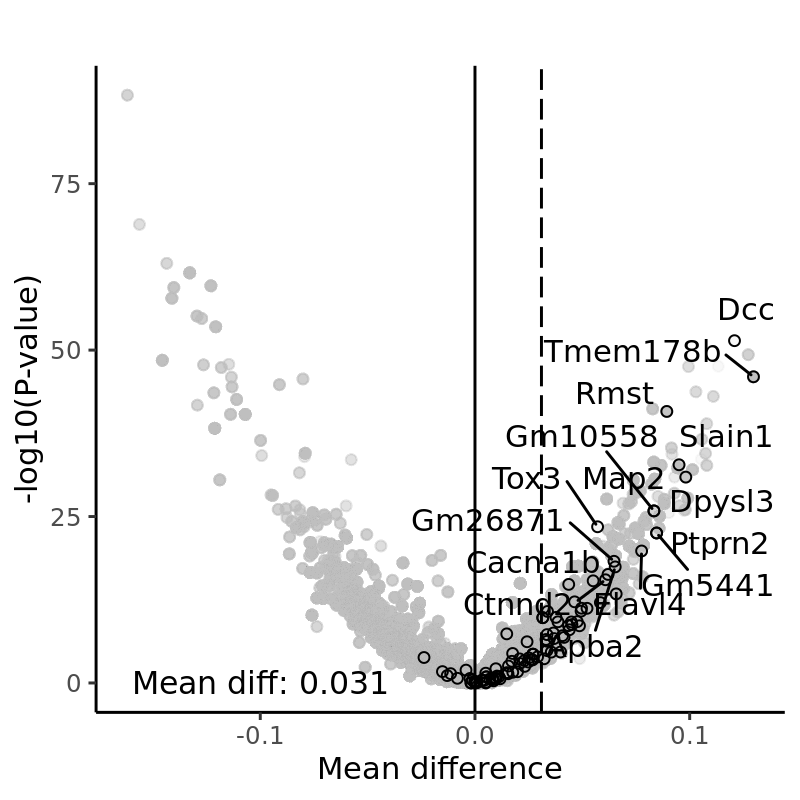

In [18]:
b

Warning message:
“Removed 42495 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 42495 rows containing non-finite values (stat_cor).”
Warning message:
“Removed 42495 rows containing missing values (geom_point).”


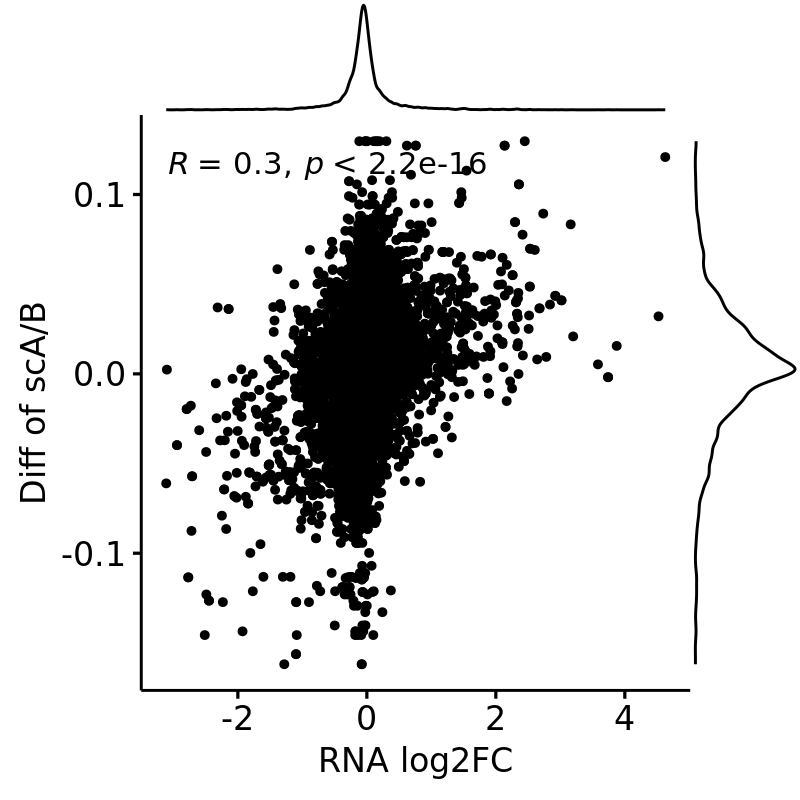

In [19]:
meso_ecto_data %>% left_join(temp,by="name") %>% ggscatter(x="avg_log2FC",y="mean_diff",size = 1,cor.coef = T) + 
    xlab("RNA log2FC") + ylab("Diff of scA/B")->p
ggMarginal(p, type = "density")